## Salary Prediction

### Import Libraries

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st

### Read Data

In [34]:
salary_df = pd.read_csv('Salary_Data_Based_country_and_race.csv')
salary_df.head()

,Unnamed: 0,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,UK,White
1,1,28.0,Female,Master's,Data Analyst,3.0,65000.0,USA,Hispanic
2,2,45.0,Male,PhD,Senior Manager,15.0,150000.0,Canada,White
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,USA,Hispanic
4,4,52.0,Male,Master's,Director,20.0,200000.0,USA,Asian


Get Some Statistics

In [35]:
salary_df.describe()

,Unnamed: 0,Age,Years of Experience,Salary
count,6704.000000,6702.000000,6701.000000,6699.000000
mean,3351.500000,33.620859,8.094687,115326.964771
std,1935.422435,7.614633,6.059003,52786.183911
min,0.000000,21.000000,0.000000,350.000000
25%,1675.750000,28.000000,3.000000,70000.000000
50%,3351.500000,32.000000,7.000000,115000.000000
75%,5027.250000,38.000000,12.000000,160000.000000
max,6703.000000,62.000000,34.000000,250000.000000


In [36]:
salary_df.describe(include='object')

,Gender,Education Level,Job Title,Country,Race
count,6702,6701,6702,6704,6704
unique,3,7,193,5,10
top,Male,Bachelor's Degree,Software Engineer,USA,White
freq,3674,2267,518,1360,1968


Find null values

In [37]:
salary_df.isnull().sum()

Unnamed: 0             0
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
Country                0
Race                   0
dtype: int64

In [38]:
# Since there aren't many null values, I choose to drop all rows containing null value
salary_df.dropna(inplace=True)
salary_df.shape

(6698, 9)

Drop Not need Rows and Columns

In [39]:
# Drop duplicates if there is any
salary_df.drop_duplicates(inplace=True)

# We can drop the first row, since it's just the index
salary_df.drop(columns=['Unnamed: 0'], inplace=True)
print(salary_df.shape)

salary_df.head(5)

(6698, 8)


,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,UK,White
1,28.0,Female,Master's,Data Analyst,3.0,65000.0,USA,Hispanic
2,45.0,Male,PhD,Senior Manager,15.0,150000.0,Canada,White
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,USA,Hispanic
4,52.0,Male,Master's,Director,20.0,200000.0,USA,Asian


### EDA

Age

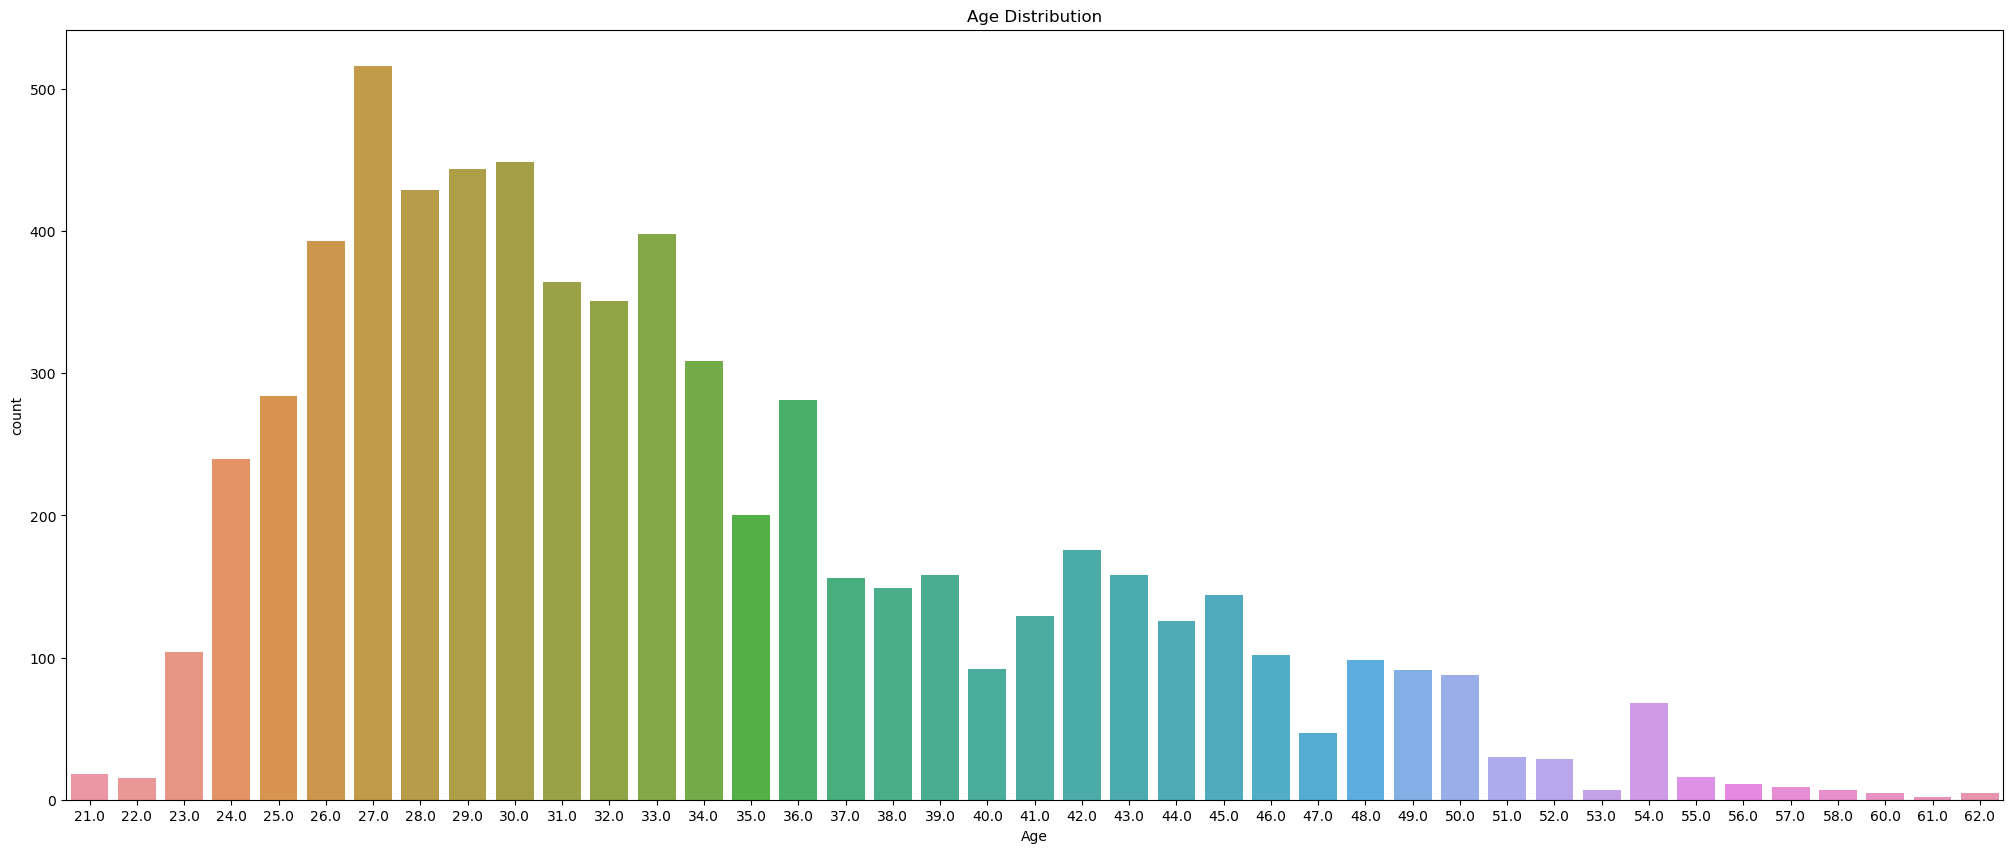

In [40]:
plt.figure(figsize=(25, 10))
plt.title('Age Distribution')
sns.countplot(data=salary_df, x='Age')
plt.show()

Gender

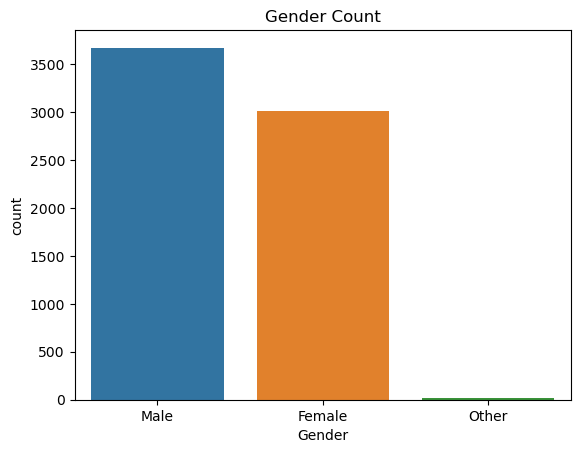

In [41]:
# gender_count = salary_df['Gender'].value_counts()

# plt.pie(x=gender_count, labels=gender_count.index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=1.5)
# plt.show()

plt.title('Gender Count')
sns.countplot(data=salary_df, x='Gender')
plt.show()

Education Level

Bachelor's Degree    2265
Master's Degree      1860
PhD                  1369
Bachelor's            756
High School           448
Name: Education Level, dtype: int64


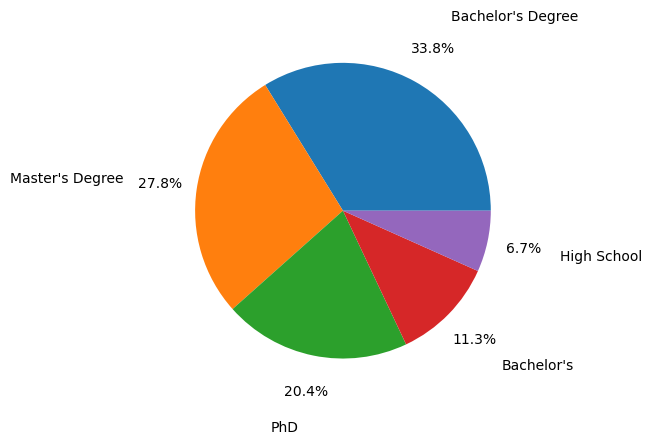

In [43]:
education_count = salary_df['Education Level'].value_counts()
print(education_count)

# I notice that Master's and Master's Degree are the same. PhD and phD are the same.
salary_df['Education Level'].replace(to_replace=['phD', 'Master\'s'], value=['PhD', 'Master\'s Degree'], inplace=True)

plt.pie(x=education_count, labels=education_count.index, autopct='%1.1f%%', pctdistance=1.25, labeldistance=1.5)
plt.show()